In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import numpy as np
import pylab as plt

from astropy.stats import sigma_clip

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitParabola, parabola
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot
from utils.utils import midPoint

In [3]:
from scipy.optimize import least_squares

def parabolaFit(x, y, z, guess, bounds=None, 
                max_nfev=10000, ftol=1e-12, 
                xtol=1e-12, verbose=False):
    
    # Set boundaries for the fit parameters.
    if bounds is None:
        inf = np.inf
        pi2 = 2*np.pi
        b1 = [0., -inf, -inf, -inf, -pi2, -pi2]
        b2 = [inf, inf,  inf,  inf,  pi2,  pi2]
        bounds = (b1, b2)
    
    # Robust fit: weights outliers outside of f_scale less
    loss = "soft_l1"
    f_scale = 1.0

    method = fitParabola
    args = (x.flatten(), y.flatten(), z.flatten())
    
    r = least_squares(method,
                      guess,
                      args=args,
                      bounds=bounds,
                      max_nfev=max_nfev,
                      loss=loss,
                      f_scale=f_scale,
                      ftol=ftol,
                      xtol=xtol)
    return r

def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        x_ = x[~mask]
        y_ = y[~mask]
        z_ = z[~mask]
        fit = parabolaFit(x_, y_, z_, guess, bounds=bounds)
        cor = np.hstack((-1*fit.x[1:4],fit.x[4:],0))
        xdr, ydr, zdr = shiftRotateXYZ(x, y, z, cor)
        zp = parabola(xdr, ydr, fit.x[0])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = res.mask
    
    return fit, mask

def removeParabolaScan(filename, iters, n=512, guess=[60., 0, 0, -50., 0, 0], bounds=None, fit=None):
    """
    """
    
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(178)])
    
    if fit is None:
        fit_, mask = parabolaFitIterations(xg, yg, zg, guess=guess, bounds=bounds, iters=iters)
        fit = fit_
    else:
        mask = False
        
    cor = np.hstack((-1*fit.x[1:4],fit.x[4:],0))
    xgdr, ygdr, zgdr = shiftRotateXYZ(xg, yg, zg, cor)
    zgdr[mask] = np.nan
    tht = np.arctan2(np.nanmax(zgdr)-np.nanmin(zgdr), np.nanmax(ygdr)-np.nanmin(ygdr))
    xgr, ygr, zgr = shiftRotateXYZ(xgdr, ygdr, zgdr, [0, 0, 0, -tht, 0, 0])
    zp = parabola(xgdr, ygdr, fit.x[0])
    _, _, zpr = shiftRotateXYZ(xgdr, ygdr, zp, [0, 0, 0, -tht, 0, 0])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        diff = sigma_clip(zgr - zpr)
        
    return xgr, ygr, diff, fit

In [4]:
n = 512
iters = 2
nZern = 36
guess = [60., 0., 0., -50., 0., 0.]
iz = 13
izv = -534
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [5]:
%%time
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
xr, yr, rDiff, rFit = removeParabolaScan(refScan, iters, n=512, guess=[60., 0, 0, -50., 0, 0], bounds=None)

CPU times: user 2min 5s, sys: 1min 50s, total: 3min 55s
Wall time: 17.3 s


In [6]:
sigScan = "{0}/2020_03_16_02:21:06.ptx.csv".format(scanDir)
xs, ys, sDiff, sFit = removeParabolaScan(sigScan, iters, n=512, guess=[60., 0, 0, -50., 0, 0])

<IPython.core.display.Javascript object>


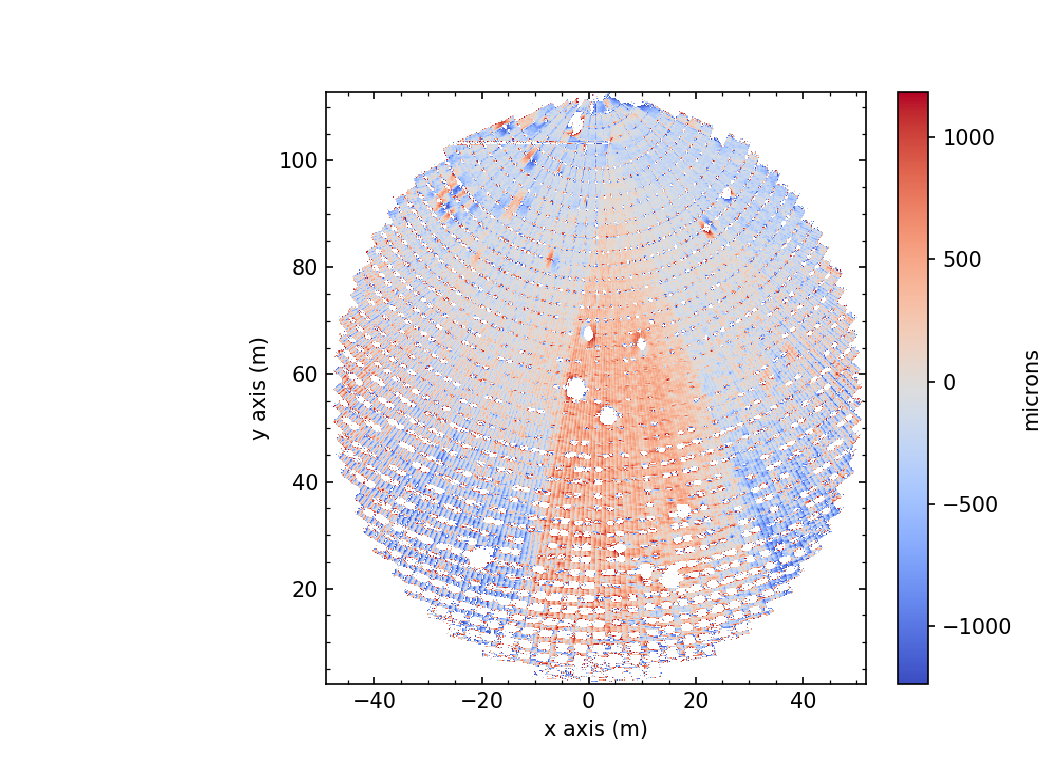

/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


390.5492574657932


In [11]:
diff = sigma_clip(sDiff - rDiff, 3)*1e6
xDiff = xr
yDiff = yr

vmin = np.nanmin(diff)
vmax = np.nanmax(diff)
surfacePlot(xr, yr, diff.T, vMin=vmin, vMax=vmax, midPoint=(vmax+vmin)/2., colorbarLabel="microns", filename="scan_pie.pdf")
print(diff.std())

In [1]:
from astropy.io import fits
hdu = fits.open("/home/gbtdata/TLASSI_200315/LASSI/2020_03_16_02:21:06.fits")
hdu[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'NRAO Green Bank'    /                                                
INSTRUME= 'LASSI   '           / device or program of origin                    
GBTMCVER= '19.4    '           / telescope control software release             
FITSVER = '2.1     '           / FITS definition version for this device        
DATEBLD = 'DATEBLD  goes  here' / time program was linked                       
SIMULATE=                    0 / Is the instrument in simulate mode?            
DATE-OBS= '2020-03-16T02:21: